In [1]:
import geopandas as gpd
import pandas as pd

import networkx as nx
import osmnx as ox

import numpy as np
import matplotlib.pyplot as plt
import folium

import os
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString
from descartes import PolygonPatch

<h2>Adding Datasets</h2>

In [2]:
#Seattle City Boundary Polygon
seaCity = gpd.read_file("./data/Seattle_Area_Polygon_-142470933516081067.geojson")
seaCity = seaCity.to_crs('EPSG:32610')

In [18]:
#Seattle Bike Facilities
sGraph = ox.load_graphml('./data/Sgraph.graphml')

<h3>Plots</h3>

<Axes: >

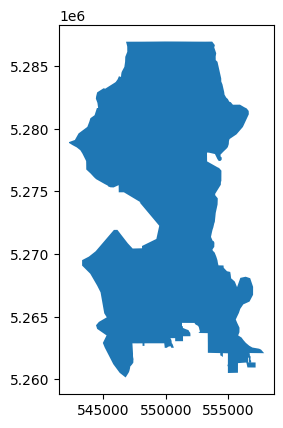

In [4]:
seaCity.plot()

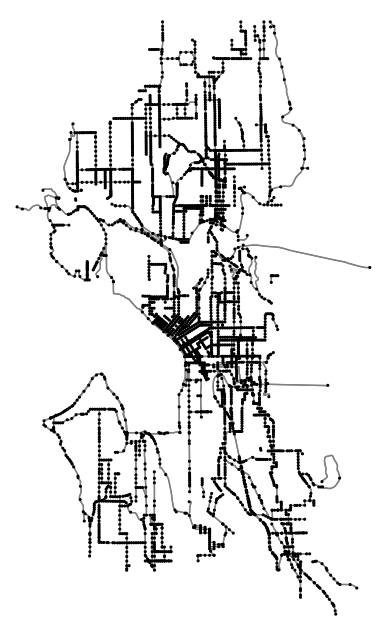

In [5]:
fig, ax = ox.plot_graph(sGraph, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

<h2>Isochrone Polygons</h2>

In [6]:
#seattledf = pd.DataFrame({"City": ["Seattle"], "Latitude": [47.605465173774206], "Longitude": [-122.3192423656039],})
#sPoint = gpd.GeoDataFrame(seattledf, geometry=gpd.points_from_xy(seattledf.Longitude, seattledf.Latitude), crs='EPSG:32610')
#sPoint = sPoint.to_crs('EPSG:32610')
#sCoords = [sPoint['geometry'].y.values[0], sPoint['geometry'].x.values[0]]
#sNode = ox.distance.nearest_nodes(sGraph, X=sCoords[1], Y=sCoords[0], return_dist=False)

In [7]:
#maybe need to reporject graph
#graph_proj = ox.project_graph(g, to_crs=None)

In [8]:
sCoords = [47.605465173774206, -122.3192423656039]
sNode = ox.distance.nearest_nodes(sGraph, X=sCoords[1], Y=sCoords[0], return_dist=False)

In [9]:
nodes = ox.graph_to_gdfs(sGraph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(sGraph, nodes=False, edges=True)

In [10]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in sGraph.edges.data():
    data['time'] = data['length'] / meters_per_minute

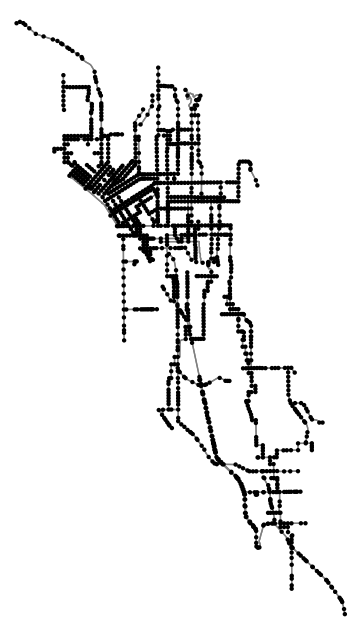

In [11]:
subgraph = nx.ego_graph(sGraph, sNode, radius=360, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [12]:
trip_times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_83244/2306092675.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [13]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph1 = nx.ego_graph(sGraph, sNode, radius=trip_time, distance="time")
    for node in subgraph1.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in sGraph.nodes()]
ns = [10 if node in node_colors else 0 for node in sGraph.nodes()]

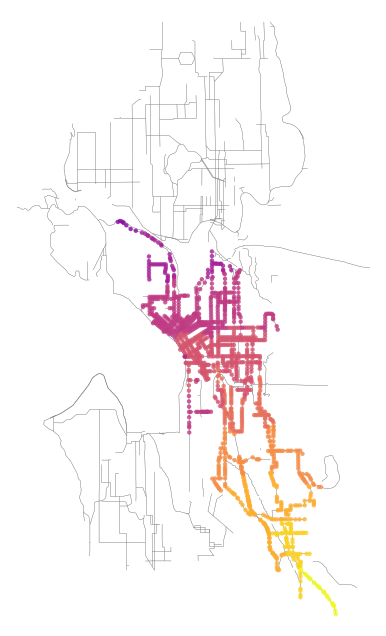

In [14]:
fig, ax = ox.plot_graph(sGraph, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [19]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, sNode, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [22]:
isochrone_polys = make_iso_polys(sGraph, edge_buff=25, node_buff=0, infill=True)

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

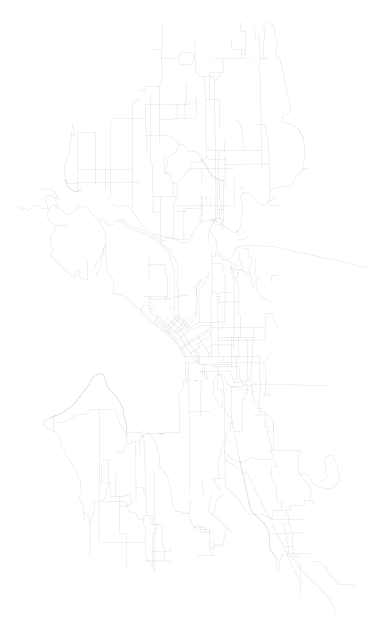

In [23]:
fig, ax = ox.plot_graph(sGraph, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

<h2>Accessibility Calculations</h2>

In [ ]:
#Area of isopolygons might be off. Am I doing the right function?

In [51]:
sArea = seaCity.area/1000000

In [54]:
min10 = isochrone_polys[-1]
area10 = min10.area/1000000
per10 = area10/sArea
print(f'{per10[0]:.2f}% of Seattle is accessibile by bike within 10 minutes from the city center.')

0.00% of Seattle is accessibile by bike within 10 minutes from the city center.


In [55]:
min30 = isochrone_polys[-3]
area30 = min30.area/1000000
area30
per30 = area30/sArea
print(f'{per30[0]:.2f}% of Seattle is accessibile by bike within 30 minutes from the city center.')

0.00% of Seattle is accessibile by bike within 30 minutes from the city center.


In [56]:
min60 = isochrone_polys[-6]
area60 = min60.area/1000000
area60
per60 = area60/sArea
print(f'{per60[0]:.2f}% of Seattle is accessibile by bike within 60 minutes from the city center.')

0.01% of Seattle is accessibile by bike within 60 minutes from the city center.


In [57]:
min90 = isochrone_polys[3]
area90 = min90.area/1000000
area90
per90 = area90/sArea
print(f'{per90[0]:.2f}% of Seattle is accessibile by bike within 90 minutes from the city center.')

0.03% of Seattle is accessibile by bike within 90 minutes from the city center.


In [59]:
min120 = isochrone_polys[0]
area120 = min120.area/1000000
area120
per120 = area120/sArea
print(f'{per120[0]:.2f}% of Seattle is accessibile by bike within 120 minutes from the city center.')

0.04% of Seattle is accessibile by bike within 120 minutes from the city center.


<h2>Open Street Data</h2>

<h3>Seattle</h3>

In [66]:
seattleG = ox.graph_from_place('Seattle, Washington, USA', network_type='bike')

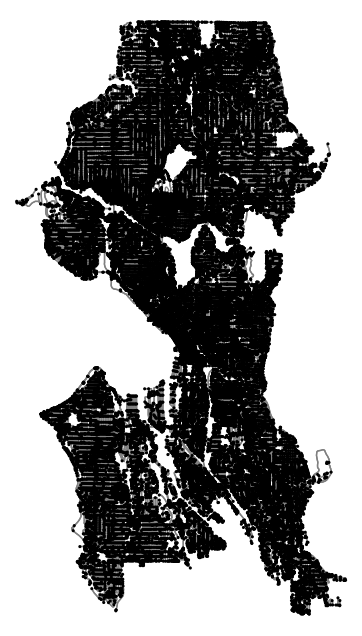

In [67]:
# Plot map
fig, ax = ox.plot_graph(seattleG, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

In [68]:
sCoords = [47.605465173774206, -122.3192423656039]
sNode = ox.distance.nearest_nodes(seattleG, X=sCoords[1], Y=sCoords[0], return_dist=False)

In [69]:
nodes = ox.graph_to_gdfs(seattleG, nodes=True, edges=False)
edges = ox.graph_to_gdfs(seattleG, nodes=False, edges=True)

In [70]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in seattleG.edges.data():
    data['time'] = data['length'] / meters_per_minute

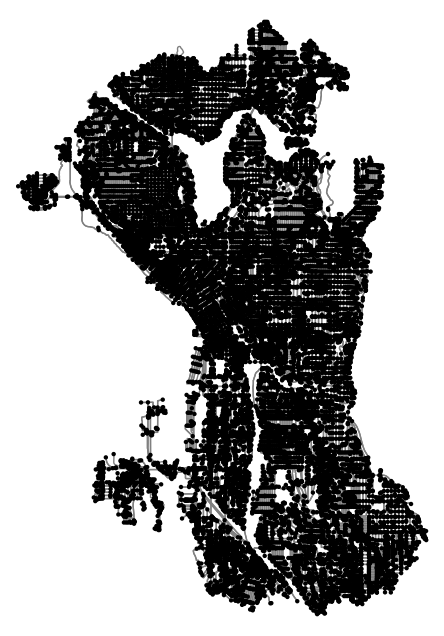

In [75]:
subgraph = nx.ego_graph(seattleG, sNode, radius=30, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [76]:
trip_times = [5, 10, 15, 20, 25, 30]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_78626/3036243802.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [77]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph1 = nx.ego_graph(seattleG, sNode, radius=trip_time, distance="time")
    for node in subgraph1.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in seattleG.nodes()]
ns = [10 if node in node_colors else 0 for node in seattleG.nodes()]

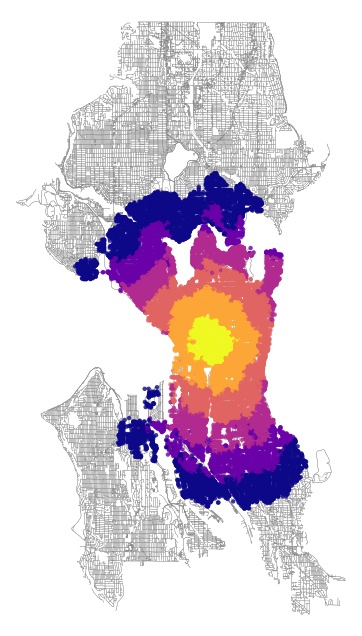

In [78]:
fig, ax = ox.plot_graph(seattleG, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [54]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, sNode, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [55]:
isochrone_polys = make_iso_polys(seattleG, edge_buff=25, node_buff=0, infill=True)

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

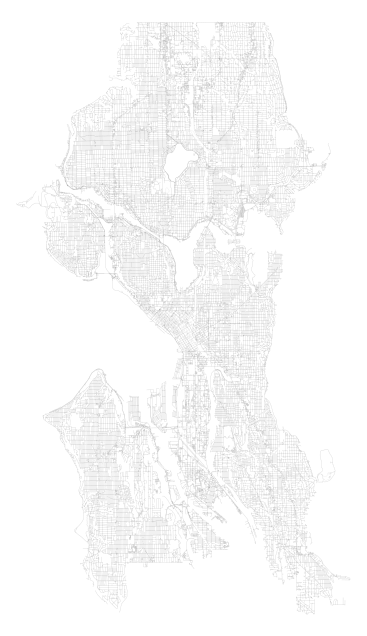

In [56]:
fig, ax = ox.plot_graph(seattleG, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

<h3>Amsterdam</h3>

In [64]:
AmsterG = ox.graph_from_place('Amsterdam, North Holland, Netherlands', network_type='bike')

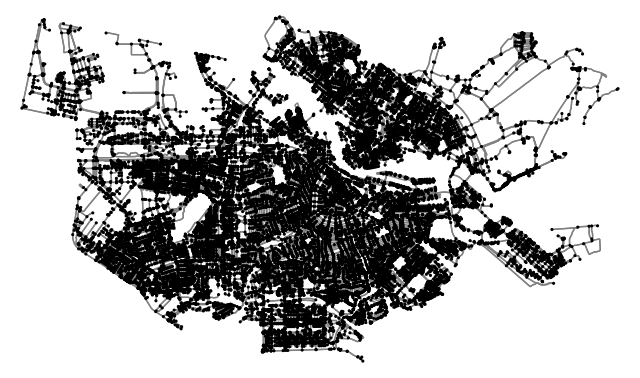

In [65]:
# Plot map
fig, ax = ox.plot_graph(AmsterG, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

In [79]:
aCoords = [52.367968834647755, 4.903949560729881]
aNode = ox.distance.nearest_nodes(AmsterG, X=aCoords[1], Y=aCoords[0], return_dist=False)

In [ ]:
#project after creating node

In [80]:
nodes = ox.graph_to_gdfs(AmsterG, nodes=True, edges=False)
edges = ox.graph_to_gdfs(AmsterG, nodes=False, edges=True)

In [81]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in AmsterG.edges.data():
    data['time'] = data['length'] / meters_per_minute

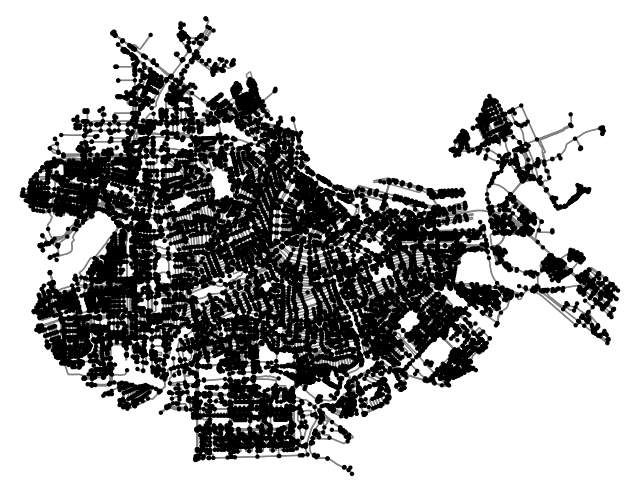

In [84]:
subgraph = nx.ego_graph(AmsterG, aNode, radius=30, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [85]:
trip_times = [5, 10, 15, 20, 25, 30]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_78626/3036243802.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [86]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph2 = nx.ego_graph(AmsterG, aNode, radius=trip_time, distance="time")
    for node in subgraph2.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in AmsterG.nodes()]
ns = [10 if node in node_colors else 0 for node in AmsterG.nodes()]

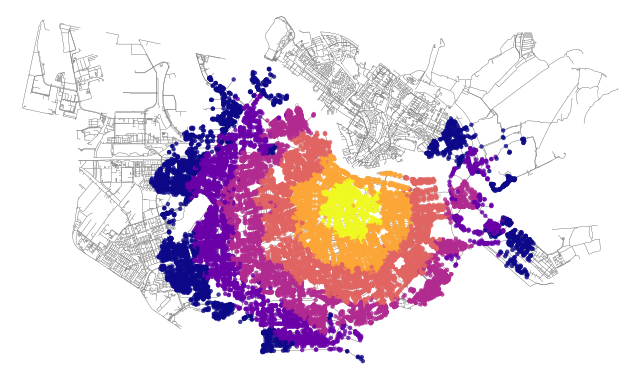

In [87]:
fig, ax = ox.plot_graph(AmsterG, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [90]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, aNode, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [91]:
isochrone_polys = make_iso_polys(AmsterG, edge_buff=25, node_buff=0, infill=True)

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [ ]:
fig, ax = ox.plot_graph(AmsterG, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()